In [25]:
import numpy as np
import pandas as pd
import sys, os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
from supDem import *
from rollingHorizon import *

# Supply and Demand

In [2]:
dfDemand,s_others_yearly,e_others_yearly=SupDem(save=False)
indSupplySolar,indSupplyWind,indDemand=indSupDem(dfDemand,s_others_yearly,e_others_yearly)

Adjusted number of community panels to: 32000


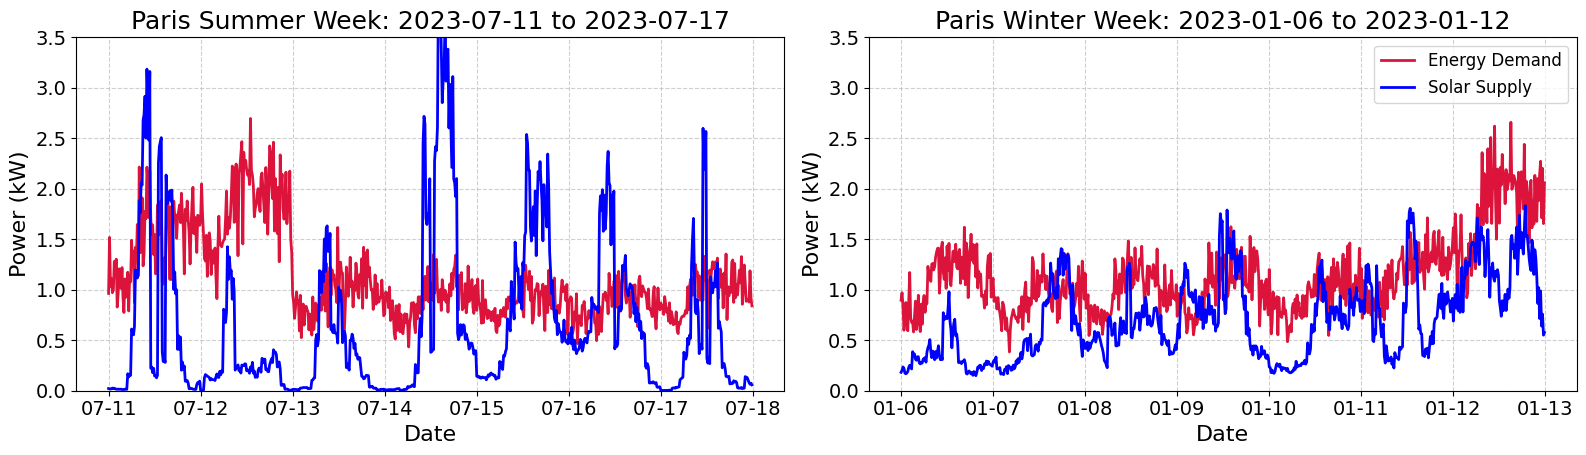

In [7]:

import matplotlib.dates as mdates
myFmt = mdates.DateFormatter('%m-%d')

# --- 6. Plot the Individual Profiles for Visual Confirmation ---
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16, 5))
# fig.suptitle('Generated Individual Household Energy Profiles', fontsize=24, y=0.95)

# Plot 1: Sample Summer Week
start_date_summer = '2023-07-11'
end_date_summer = '2023-07-17'
ax1.plot(indDemand.loc[start_date_summer:end_date_summer], label="Energy Demand", color='crimson', linewidth=2)
ax1.plot((indSupplySolar+indSupplyWind).loc[start_date_summer:end_date_summer], label="Solar Supply", color='blue', linewidth=2)
ax1.set_title(f"Paris Summer Week: {start_date_summer} to {end_date_summer}", fontsize=18)
ax1.set_ylabel("Power (kW)", fontsize=16)
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.set_ylim(top=3.5,bottom=0)
ax1.xaxis.set_major_formatter(myFmt)
start_date_winter = '2023-01-06'
end_date_winter = '2023-01-12'
ax2.plot(indDemand.loc[start_date_winter:end_date_winter], label="Energy Demand", color='crimson', linewidth=2)
ax2.plot((indSupplySolar+indSupplyWind).loc[start_date_winter:end_date_winter], label="Solar Supply", color='blue', linewidth=2)
ax2.set_xlabel("Date", fontsize=16)
ax2.set_title(f"Paris Winter Week: {start_date_winter} to {end_date_winter}", fontsize=18)
ax2.set_ylabel("Power (kW)", fontsize=16)
ax2.legend(fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.6)
ax2.tick_params(axis='both', which='major', labelsize=14)
ax2.set_ylim(top=3.5,bottom=0)
ax2.xaxis.set_major_formatter(myFmt)
ax1.set_xlabel("Date", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()


C:\Users\lleone\AppData\Local\Temp\ipykernel_20652\4122868943.py:12: Pandas4Warning: Starting with pandas version 4.0 all arguments of mean will be keyword-only.
  )/daily_demand.iloc[i-7:i+7]).mean(0), color=cmap(norm(i)), alpha=0.5)


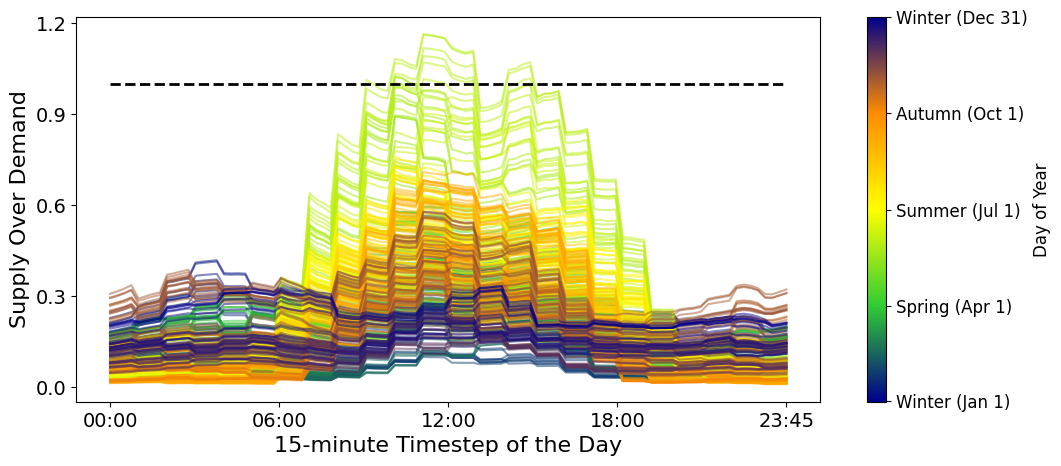

In [24]:
daily_demand = dfDemand["consumption"].to_frame(name='val').pivot_table(index=dfDemand.index.date, columns=dfDemand.index.time, values='val')
daily_supply = s_others_yearly.to_frame(name='val').pivot_table(index=s_others_yearly.index.date, columns=s_others_yearly.index.time, values='val')
Edaily_supply = e_others_yearly.to_frame(name='val').pivot_table(index=e_others_yearly.index.date, columns=e_others_yearly.index.time, values='val')
colors = ["#00008B", "#32CD32", "#FFFF00", "#FF8C00", "#00008B","#8900FA"]
nodes = [0.0, 0.25, 0.5, 0.75, 1.0]
cmap = LinearSegmentedColormap.from_list("seasonal_cmap_bright_spring", list(zip(nodes, colors)))
norm = mcolors.Normalize(vmin=0, vmax=365)
if s_others_yearly is not None and dfDemand is not None:
    fig,ax1 = plt.subplots(1,1,figsize=(12, 5))
    for i in range(7,len(daily_demand),):
        ax1.plot(range(daily_demand.shape[1]), ((daily_supply.iloc[i-7:i+7]+Edaily_supply.iloc[i-7:i+7]
                                                 )/daily_demand.iloc[i-7:i+7]).mean(0), color=cmap(norm(i)), alpha=0.5)
    ax1.set_ylabel("Supply Over Demand", fontsize=16)
    ax1.set_xlabel("15-minute Timestep of the Day", fontsize=16)
    ax1.set_xticks(np.linspace(0, daily_demand.shape[1] - 1, 5))
    ax1.set_yticks(np.linspace(0, 1.2, 5))
    ax1.set_xticklabels(['00:00', '06:00', '12:00', '18:00', '23:45'], fontsize=14)
    ax1.tick_params(axis='y', which='major', labelsize=14)
    ax1.grid(True, linestyle='--', alpha=0.001)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar_supply = fig.colorbar(sm, ax=ax2, orientation='vertical', label='Day of Year')
    cbar_supply.set_ticks([1, 91, 182, 274, 365])
    cbar_supply.set_ticklabels(['Winter (Jan 1)', 'Spring (Apr 1)', 'Summer (Jul 1)', 'Autumn (Oct 1)', 'Winter (Dec 31)'])
    cbar_supply.ax.tick_params(labelsize=12)
    cbar_supply = fig.colorbar(sm, ax=ax1, orientation='vertical', )
    cbar_supply.set_label('Day of Year', fontsize=12)
    cbar_supply.set_ticks([1, 91, 182, 274, 365])
    cbar_supply.set_ticklabels(['Winter (Jan 1)', 'Spring (Apr 1)', 'Summer (Jul 1)', 'Autumn (Oct 1)', 'Winter (Dec 31)'])
    cbar_supply.ax.tick_params(labelsize=12)
    ax1.plot(range(daily_demand.shape[1]),np.ones(daily_demand.shape[1]), linewidth=2,linestyle="--",color="black")
plt.show()

# Prosumer-Level Gains from Decentralization

In [ ]:
simulation_index = indDemand.index
new_demand_profile = generate_night_owl_profile(base_index=simulation_index)

# Assuming prosumer's generation is from the individual supply profile
omega_yearly = indSupplySolar+indSupplyWind
omega_yearly.columns = ['supply_kw'] # Rename column for clarity

# Remove timezone information to make all datetime indices compatible
s_others_yearly.index = s_others_yearly.index.tz_localize(None)
omega_yearly.index = omega_yearly.index.tz_localize(None)

# 2. Set alpha_base as 75% of individual demand (this is a timeseries)
pct_flex    = 0.5   ## PCT of flex consumption need
alpha_base_yearly = (1-pct_flex)* new_demand_profile['demand_kw']

# 3. Define Simulation Parameters
# Prosumer parameters
B           = 10.0  ## BATTERY CAPACITY (BATTERY STORES PUT TO B kw)
b0_initial  = 5.0   ## INITIAL BATTERY STATE
X           = 5.0   ## MAXIMUM ENERGY TRANSACTION WITH THE GRID PER TIME UNIT
K_max       = 5.0   ## MAXIMUM BATTERY CHARGE/DISCHARGE POWER (in kW)
TotalDays = 360
L_input = 4      # Fixed lookahead window
T = 24 * 4       # Time steps per day (15-minute intervals)
gamma_day = 0.99     # Epoch discount rate
gamma_hourly = gamma_day**(1/T)
hours = np.arange(0,24,24/T)
hourCreusePleine =['c','c','c','c','c','c',
                   'p','p','p','p','p','p',
                   'c',
                   'p','p','p','p','p','p','p','p','p','p',
                   'c',]
HP=0.2146
HC=0.1696
lamOverPrice=0.0886
lam_under = np.full(T, lamOverPrice)
lam_over  = np.ones(T,)
for j in range(T):
    if hourCreusePleine[floor(hours[j])]=='p':lam_over[j]=HP
    else: lam_over[j]=HC
alpha_base_yearly_T = np.zeros((360,L_input+1))


In [28]:
runRH(T,TotalDays,alpha_base_yearly,b0_initial,L_input,
          omega_yearly,s_others_yearly,indDemand,
          new_demand_profile,pct_flex,alpha_base_yearly_T,
          B, X, K_max,
          lam_under, lam_over, gamma_hourly,
          )

NameError: name 'runRH' is not defined